# Example 10: Composition scaling

In this notebook, we will calculate the free energy of a binary ZrCu system as a function of the composition. The structure that will be considered is ZrCu with a B2 structure. The potential that will be used is-

[M.I. Mendelev , M.J. Kramer , R.T. Ott , D.J. Sordelet , D. Yagodin & P. Popel (2009) Development of suitable interatomic potentials for simulation of liquid and amorphous Cu–Zr alloys, Philosophical Magazine, 89:11, 967-987](http://dx.doi.org/10.1080/14786430902832773)

We specify the mode as `composition_scaling` in the input file. The input file has a new section:

```
composition_scaling:
  input_chemical_composition:
     - Cu: 512
     - Zr: 512
  output_chemical_composition:
     - Cu: 532
     - Zr: 492
```

which provides the details for composition change. The `input_chemical_composition` shows equal number of Cu and Zr atoms as expected in the B2 structure. The `output_chemical_composition` has 532 Cu and 492 Zr atoms, which amounts to 48 at. % Zr. The composition integration therefore will span 48-50% of Zr.

As usual, the calculation can be run by:

```
calphy -i input.yaml
```

Once the calculation is run, there is a file `composition_scaling.dat` created in the simulation folder. We can read in this file, to get the information. There are a number of columns in the file, but we will just use the first two.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calphy.input import read_report

In [7]:
fe_ref_direct = read_report("fe-ZrCu.dump-800-0")
fe_sub_direct = read_report("fe-ZrCu_substitution.dump-800-0")

In [8]:
fe_ref_direct["results"]["free_energy"] - fe_sub_direct["results"]["free_energy"]

-0.003122706854647106

In [11]:
fe_sub_trf = read_report("sub-composition_scaling-ZrCu.dump-800-0")

In [12]:
fe_sub_trf["results"]["free_energy"]

0.003776726711251715

In [2]:
flambda_arr, netfe = np.loadtxt("composition_scaling-ZrCu.dump-800-0/composition_sweep.dat", unpack=True,
                               usecols=(0,1))

The first column, `flambda_arr` goes from 1.00 to 0.00. This spans the composition interval. At 1.00, the composition is 50 % Zr, while at 0.00, the composition is 48 %. First, the array is converted to the actual composition.

In [3]:
comp = 0.50-flambda_arr*(0.50-0.48)

To compare our results, we will use the data from this publication:

[Tang, C, and Peter Harrowell. “Predicting the Solid State Phase Diagram for Glass-Forming Alloys of Copper and Zirconium.” Journal of Physics: Condensed Matter 24, no. 24 (June 20, 2012): 245102.](https://doi.org/10.1088/0953-8984/24/24/245102)

In [4]:
comp_reference = np.array([0.4810, 0.4913, 0.5])
fe_reference = np.array([-5.27, -5.31, -5.34])

We will also use direct calculations done using calphy. The results from direct calculations are given here for easiness.

In [5]:
comp_direct = np.array([0.48, 0.49, 0.50])
fe_direct = np.array([-5.271, -5.311, -5.350])

Note that our results, `netfe` only includes the free energy difference as composition change. We will modify the other calculations to plot the energy difference.

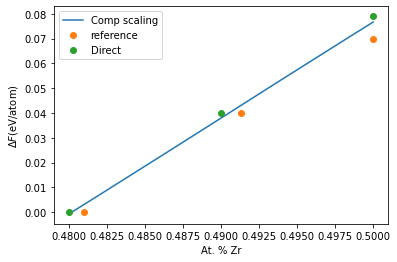

In [7]:
plt.plot(comp, netfe, label="Comp scaling")
plt.plot(comp_reference, fe_reference[0]-fe_reference, "o", label="reference")
plt.plot(comp_direct, fe_direct[0]-fe_direct, "o", label="Direct")
plt.legend()
plt.xlabel("At. % Zr")
plt.ylabel(r"$ \Delta F $(eV/atom)");

As seen from the plot, we have excellent agreement. However, we can obtain the whole range from a single calculation.